# CIS 545 Project

 ** Yixue Wendy Feng**


## Import and Data loading

In [1]:
%%capture
!pip install -U gensim
!pip install urllib2
!pip install wordcloud

In [2]:
# check gensim version
import gensim
gensim.__version__

'3.8.1'

In [133]:
# import stuff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from collections import Counter

from gensim import corpora
from gensim.models import LsiModel, KeyedVectors
from gensim.models.tfidfmodel import TfidfModel
from gensim.models.nmf import Nmf
from gensim.matutils import corpus2dense

import sklearn.model_selection as ms
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

from datetime import *
from operator import itemgetter

In [0]:
%%capture
!wget https://cis.upenn.edu/~cis545/data/reviews.dict
!wget https://cis.upenn.edu/~cis545/data/train_reviews.mm
!wget https://cis.upenn.edu/~cis545/data/train_times.npy

In [4]:
reviews_dict = corpora.Dictionary.load("reviews.dict")
reviews_bow = corpora.MmCorpus('train_reviews.mm')
reviews_times  = np.load('train_times.npy')
reviews_times.shape = (len(reviews_bow),1)
ratings = np.vstack((np.repeat(1, 4000), np.repeat(2, 4000), np.repeat(3, 4000), np.repeat(4, 4000), np.repeat(5, 4000)))
ratings = np.repeat(ratings, 5)

## Exploring Gensim Format

This section includes helper functions that help us better understand and represent the given data. Most of these are from homework 4.

In [5]:
# Get word from reviews_dict by index 
print(reviews_dict[10])
# Get index from reviews_dict by word
print(reviews_dict.token2id['certain'])

certain
10


In [6]:
# Get reviews in BOW from reviews_bow by list of indices
def lookup_reviews(corpus, indices):
    return [doc for i,doc in enumerate(corpus) if i in indices]

docs = lookup_reviews(reviews_bow, [0,1])
print(docs[0])

[(0, 1.0), (1, 1.0), (2, 1.0), (3, 2.0), (4, 1.0), (5, 1.0), (6, 5.0), (7, 1.0), (8, 1.0), (9, 1.0), (10, 1.0), (11, 1.0), (12, 3.0), (13, 1.0), (14, 2.0), (15, 1.0), (16, 1.0), (17, 1.0), (18, 1.0), (19, 1.0), (20, 1.0), (21, 1.0), (22, 1.0), (23, 1.0), (24, 4.0), (25, 1.0), (26, 2.0), (27, 1.0), (28, 1.0), (29, 2.0), (30, 1.0), (31, 1.0), (32, 1.0), (33, 1.0), (34, 1.0), (35, 1.0), (36, 1.0), (37, 1.0), (38, 1.0), (39, 1.0), (40, 1.0), (41, 1.0), (42, 1.0), (43, 1.0), (44, 2.0), (45, 1.0), (46, 2.0), (47, 1.0), (48, 1.0), (49, 1.0), (50, 1.0), (51, 1.0), (52, 1.0), (53, 1.0), (54, 1.0), (55, 2.0)]


In [7]:
# Translate reviews in reviews_bow using reviews_dict
def translate_review(review, reviews_dict):
    words = []
    for (ind, count) in review:
        word = dict(reviews_dict)[ind]
        for i in range(int(count)):
            words.append(word)
    return ' '.join(words)

print(translate_review(docs[0], reviews_dict))

abl aggress also apart apart aussi away ball ball ball ball ball better cairn came certain chewer come come come design destroy destroy disappoint expos fast favorit good great hard insid just kong kong kong kong larg lb lb let littl medium medium mix money much open orka play remov roll seam short someth sorri sort squeak squeez squeez supervis terrier terrier think took tore toy tri usual wast weigh will will


In [8]:
# Convert to pandas Timestamp
def convert_times(reviews_times):
    s = pd.Series(reviews_times.reshape(-1))
    return s.apply(lambda x: datetime.fromtimestamp(x))

converted_times = convert_times(reviews_times)
print(converted_times[0], type(converted_times[0]))

2012-05-05 20:00:00 <class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [9]:
# Getting year, month, day from time
date = converted_times[0]
print(date.year, date.month, date.day)

2012 5 5


## Exploring Data

### Some Fun Stuff

Let's first use wordcloud to visualize some reviews. Since we don't have the reviews sentences, it could be helpful to use wordcloud to visualize the what the reviews are about.

In [195]:
## Get some 1-star reviews
bad_docs = lookup_reviews(reviews_bow, range(0,100))
bad_reviews = ""
for i in bad_docs:
    bad_reviews += translate_review(i, reviews_dict)

In [196]:
## Get some 5-star reviews
good_docs = lookup_reviews(reviews_bow, range(90000,90100))
good_reviews = ""
for i in good_docs:
    good_reviews += translate_review(i, reviews_dict)

Bad reviews:


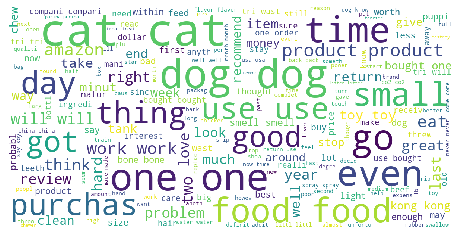

Good reviews: 


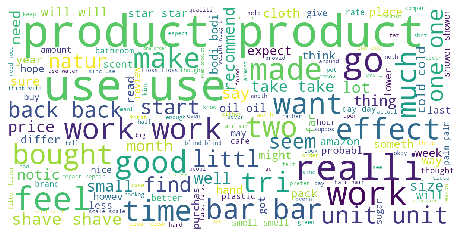

In [198]:
from wordcloud import WordCloud

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (8, 10))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
print("Bad reviews:")
show_wordcloud(bad_reviews)
print("Good reviews: ")
show_wordcloud(good_reviews)

The quality of the products in the reviews is not really reflected in the wordcloud (as fun as they are). Now let's do more analysis!

### TFIDF Representation

In [10]:
def make_tfidf(reviews_bow):
    model = TfidfModel(reviews_bow)
    corpus_tfidf = model[reviews_bow]
    return corpus_tfidf

In [11]:
reviews_tfidf = make_tfidf(reviews_bow)
print(lookup_reviews(reviews_tfidf,[0]))

[[(0, 0.0660034180373639), (1, 0.12360093748348407), (2, 0.0407796613402426), (3, 0.15992050393599033), (4, 0.15541949979737957), (5, 0.06403024792327237), (6, 0.4183486031794299), (7, 0.045007373378449185), (8, 0.18913727393566332), (9, 0.06641339282532265), (10, 0.10413115494146216), (11, 0.10825486685420439), (12, 0.15525820361308584), (13, 0.06519736368026895), (14, 0.2067794919463751), (15, 0.06590094883325925), (16, 0.1158324947414227), (17, 0.08493483571495053), (18, 0.08755539750744058), (19, 0.0338354240398617), (20, 0.03669439920511), (21, 0.057670953991595504), (22, 0.07051020376459982), (23, 0.028157675316733372), (24, 0.44250466469710886), (25, 0.06111733364998563), (26, 0.17050232085388733), (27, 0.07454444489391773), (28, 0.040576679631273434), (29, 0.17164557258925867), (30, 0.08175891731909864), (31, 0.05823720551567898), (32, 0.039456211128453836), (33, 0.062362256150244405), (34, 0.20042926732827837), (35, 0.06911419139133088), (36, 0.07004236227439306), (37, 0.08512

## Reconstructing Data to Dense Form

Before we predict ratings from reviews, we need to transform the sparse reviews data to dense matrix form of size NxP. Using the original full dictionary, P=18716; and using the outputs from the topic model, we pick the P = 1000.

### Full Feature Set

We first expand the sparse reviews data using the full feature set (reviews_dict). Gensim provides a function corpus2dense() that can allow us to do this more efficiently than the densify() function implemented in HW4. 

In [12]:
dense_corpus_full = corpus2dense(reviews_tfidf, len(reviews_dict)).T
dense_corpus_full.shape

(100000, 18716)

### Topic Modeling

Here we use the LsiModel from gensim used in HW4, to reduce the dimensionality of the data before moving on to prediction. The cutoff is set to be 1000. We can also print out the topics for *fun* (it seems there are a lot to do with pets).

In [13]:
cutoff = 1000
tfidf_topic_model = LsiModel(reviews_tfidf, id2word=reviews_dict, num_topics=cutoff)
vec_corpus_tfidf = tfidf_topic_model[reviews_tfidf] 

In [14]:
tfidf_topic_model.print_topics(5)

[(0,
  '0.141*"use" + 0.136*"like" + 0.135*"one" + 0.122*"dog" + 0.121*"work" + 0.120*"just" + 0.119*"size" + 0.119*"get" + 0.115*"product" + 0.112*"fit"'),
 (1,
  '-0.362*"shoe" + -0.315*"size" + 0.313*"dog" + 0.276*"cat" + -0.242*"fit" + -0.236*"wear" + 0.194*"toy" + 0.162*"food" + -0.141*"order" + -0.141*"comfort"'),
 (2,
  '-0.512*"dog" + -0.265*"toy" + -0.251*"shoe" + -0.230*"cat" + -0.229*"size" + 0.175*"bottl" + -0.172*"treat" + -0.149*"food" + -0.140*"chew" + 0.139*"use"'),
 (3,
  '-0.739*"cat" + 0.424*"dog" + -0.237*"litter" + -0.186*"shoe" + -0.137*"box" + 0.120*"toy" + 0.110*"chew" + -0.101*"food" + 0.097*"seat" + 0.082*"babi"'),
 (4,
  '0.413*"toy" + 0.259*"seat" + -0.236*"dog" + 0.225*"babi" + -0.216*"product" + 0.198*"cat" + 0.183*"love" + 0.182*"play" + -0.153*"shoe" + -0.149*"food"')]

Similar to the previous step, we densify the reduced output from the LSI model to be used for predicting star ratings.

In [15]:
dense_corpus = corpus2dense(vec_corpus_tfidf, cutoff).T

In [16]:
print(dense_corpus.shape, type(dense_corpus))

(100000, 1000) <class 'numpy.ndarray'>


## Predicting Star Rating

### Train Val Test Split

Sklearn provides a StratifiedShuffleSplit function that split the data into train and test while keeping the class balanced in each split. Although in this dataset, the numbers of reviews for each rating 1-5 are all the same, it's good practice to make sure we have a balanced dataset. 

In [17]:
from sklearn.model_selection import StratifiedShuffleSplit

def train_test_split(X, Y, test_size = 0.2, random_state = 0):
    X = [1 for i in range(len(X))]
    sss = StratifiedShuffleSplit(test_size = test_size, n_splits = 20, random_state = random_state)
    train, test = next(sss.split(X, Y))
    return train, test


def train_val_test_split(X, Y, n_splits = 10, test_size = 0.2, 
                         val_size = 0.2, random_state = 0):
    '''val_size is the percentage of validation data from the first split'''
    train_val, test = train_test_split(X, Y, 
                                       test_size = test_size, random_state = random_state)
    train, val = train_test_split(X[train_val], Y[train_val],
                                  test_size = val_size, random_state = 0)
    return train, val, test

In [18]:
train, test = train_test_split(dense_corpus, ratings, test_size = 0.2,
                                   random_state = 0)
print(train.shape, test.shape)

(80000,) (20000,)


### Random Forest Model

Replicate the result from the homework to use as baseline (this model uses) using output from the LsiModel (cutoff=1000).

In [19]:
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

X_train = dense_corpus[train]
Y_train = ratings[train]
X_test = dense_corpus[test]
Y_test = ratings[test]

print("X_train: ", X_train.shape)
print("Y_train: ", Y_train.shape)
print("X_test: ", X_test.shape)
print("Y_test: ", Y_test.shape)

# Here we use Counter to make sure there are equal number of ratings in each train/test split.
print(Counter(Y_train))
print(Counter(Y_test))

X_train:  (80000, 1000)
Y_train:  (80000,)
X_test:  (20000, 1000)
Y_test:  (20000,)
Counter({2: 16000, 4: 16000, 3: 16000, 5: 16000, 1: 16000})
Counter({4: 4000, 1: 4000, 3: 4000, 2: 4000, 5: 4000})


In [20]:
def accuracy (Y_pred, Y_test):
    return sum(1 for y1,y2 in zip(Y_test,Y_pred) if y1 == y2) / len(Y_test)

In [21]:
# Train the random forest classifier on 1000 components
clf = RandomForestClassifier(n_estimators=50)
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
Y_pred_train = clf.predict(X_train)

#### RF Result

In [22]:
print("Training accuracy: ", accuracy(Y_pred_train, Y_train))
print("Testing accuracy: ", accuracy(Y_pred, Y_test))
print(Counter(Y_pred))

Training accuracy:  0.998875
Testing accuracy:  0.7704
Counter({3: 4477, 4: 4101, 5: 3947, 2: 3918, 1: 3557})


In [69]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           1       0.89      0.79      0.84      4000
           2       0.80      0.78      0.79      4000
           3       0.75      0.84      0.79      4000
           4       0.68      0.70      0.69      4000
           5       0.75      0.74      0.74      4000

    accuracy                           0.77     20000
   macro avg       0.77      0.77      0.77     20000
weighted avg       0.77      0.77      0.77     20000



Sklearn classification_report result as shown above allows us to see classification results for each class. F1-scores combines both precision and recall, and we can see that it's highest for class rating=1, which is bad reviews.

In [134]:
conf = confusion_matrix(Y_test, Y_pred)
conf

array([[3165,  133,  144,  257,  301],
       [ 152, 3126,  235,  283,  204],
       [  28,  162, 3365,  329,  116],
       [  88,  253,  491, 2797,  371],
       [ 124,  244,  242,  435, 2955]])

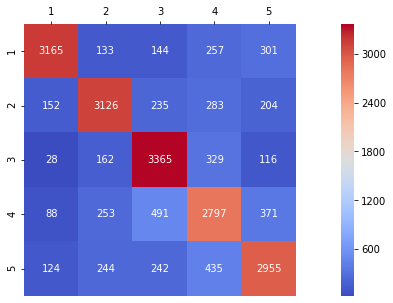

In [157]:
plt.figure(figsize = (16,5))
ax = sns.heatmap(conf, cmap = 'coolwarm', square=True, annot = True, 
                 fmt='g', xticklabels = range(1,6), yticklabels = range(1,6))
ax.xaxis.set_ticks_position('top')

We compute the confusion matrix to further investigate the classification. Each row represents the actual class from rating 1-5, and the columns represent the predicted value. For instance, for reviews with actual rating of 1, we misclassified 301 of them as rating of 5. 
<br /><br />
In different classification tasks, we might care about different things. In this case, we don't want a bad product to get a 5-star review because it's highly misleading to consumers, whereas a 5-star product getting a 1 star review is less harmful in comparison.

### Neural Net Approach

Here we attempt to use neural net for classification. A neural net is flexible in how we can design its structure. It can be used to reduce dimensionalities of data similar to PCA, but it's also dynamic and can perform non-linear transformation, unlike PCA and many other traditional machine learning methods.

In [24]:
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torchvision import transforms
from matplotlib.pyplot import figure
from torch.utils.data import Dataset, DataLoader

In [25]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
device

device(type='cpu')

#### Dataloader

Torch makes it easy to define our own Dataset class. Since the loss function requires that we label the class [0, n_class-1], we modify the labels when loading the class.

In [26]:
class Dataset(Dataset):
    def __init__(self, data, labels, transform = None):
        self.data = data
        self.labels = labels-1
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        item = self.data[index]
        if self.transform is not None:
            item = self.transform(item)
        return (item, self.labels[index])

The batch size is a hyperparameter we can tune. Small batches takes up greater memory, while large batches affect model generalization.

In [27]:
batch_size = 64

train_data = Dataset(X_train, Y_train)
val_data = Dataset(X_test, Y_test)

train_loader = DataLoader(dataset = train_data, batch_size = batch_size,
                              shuffle = True)
val_loader = DataLoader(dataset = val_data, batch_size = batch_size,
                              shuffle = True)

#### Defining Neural Net

We use 3 linear layers with ReLU activation and a Sigmoid activation after the final layer.
The **ReLU activation $y = max(0, x)$ ** is very cheap to compute, can generate a sparse model and converges faster. It's used very often compared to the tanh() activation function.

In [28]:
class FFNet(nn.Module):
    def __init__(self, n = 1000):
        super(FFNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(n, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 5),
            nn.Sigmoid()
        )
    def forward(self, x):
        x = self.net(x)
        return x

#### Model Training

In [29]:
def train_model(model, loss_fn, epochs, train_loader, val_loader, optimizer):

    train_accuracies = []; val_accuracies = []
    train_losses = []; val_losses = []

    model = model.to(device)
    loss_fn = loss_fn.cuda(device)
  
    for epoch in range(epochs):
        correct = 0.0
        cum_loss = 0.0
        
        #Training
        for (i, (inputs, labels)) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            pred = model(inputs)
            loss = loss_fn(pred, labels)

            _, max_labels = pred.max(1)
            correct += (max_labels == labels).sum().item()
            cum_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i + 1) % 300 == 0:
                print('Train-epoch %d. Iteration %05d, Avg-Loss: %.4f, Accuracy: %.4f' % 
                    (epoch, i + 1, cum_loss / (i + 1), correct / ((i + 1) * batch_size)))

        train_accuracies.append(correct / len(train))
        train_losses.append(cum_loss / (i + 1))   

        # Validation.
        correct = 0.0
        cum_loss = 0.0
        model.eval()
        for (i, (inputs, labels)) in enumerate(val_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            pred = model(inputs)
            cum_loss += loss_fn(pred, labels).item()

            _, max_labels = pred.max(1)
            correct += (max_labels == labels).sum().item()

        val_accuracies.append(correct / len(test))
        val_losses.append(cum_loss / (i + 1))

        # Logging the current results on validation.
        print('Validation-epoch %d. Avg-Loss: %.4f, Accuracy: %.4f' % 
            (epoch, cum_loss / (i + 1), correct / len(test)))
        
    return model, train_accuracies, train_losses, val_accuracies, val_losses

Below, we define the epochs to train for and learning rate. We use a **CrossEntropyLoss** as our loss function. It's often used in classification problem with multiple classes. The losses are averaged across observations for each minibatch.
<br />
We also use is the **Adam optimizer**, which is an adaptive learning rate optimizer algorithm that find individual learning rates for each parameter.
<br /><br />
We print out the average loss and accuracy for every 300 mini-batches in training, and every epoch in validation.

In [30]:
num_epochs = 20
learning_rate = 1e-4

model = FFNet(n = cutoff)
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

trained_model, train_acc, train_loss, val_acc, val_loss = train_model(model, criterion, 
                                                    num_epochs, 
                                                    train_loader, val_loader, optimizer)


Train-epoch 0. Iteration 00300, Avg-Loss: 1.6084, Accuracy: 0.2290
Train-epoch 0. Iteration 00600, Avg-Loss: 1.6002, Accuracy: 0.3182
Train-epoch 0. Iteration 00900, Avg-Loss: 1.5754, Accuracy: 0.4524
Train-epoch 0. Iteration 01200, Avg-Loss: 1.5368, Accuracy: 0.5328
Validation-epoch 0. Avg-Loss: 1.3608, Accuracy: 0.8046
Train-epoch 1. Iteration 00300, Avg-Loss: 1.3204, Accuracy: 0.8229
Train-epoch 1. Iteration 00600, Avg-Loss: 1.2923, Accuracy: 0.8264
Train-epoch 1. Iteration 00900, Avg-Loss: 1.2683, Accuracy: 0.8303
Train-epoch 1. Iteration 01200, Avg-Loss: 1.2472, Accuracy: 0.8329
Validation-epoch 1. Avg-Loss: 1.1644, Accuracy: 0.8349
Train-epoch 2. Iteration 00300, Avg-Loss: 1.1452, Accuracy: 0.8476
Train-epoch 2. Iteration 00600, Avg-Loss: 1.1351, Accuracy: 0.8479
Train-epoch 2. Iteration 00900, Avg-Loss: 1.1273, Accuracy: 0.8476
Train-epoch 2. Iteration 01200, Avg-Loss: 1.1199, Accuracy: 0.8485
Validation-epoch 2. Avg-Loss: 1.0962, Accuracy: 0.8434
Train-epoch 3. Iteration 00300,

#### Neural Net Results

We plot both the accuracy and loss for training and validation for the 20 epochs we trained on. The model seems to converge after 8-10 epochs. The testing loss is not significant larger than training, which suggests that the model generalizes fairly well.

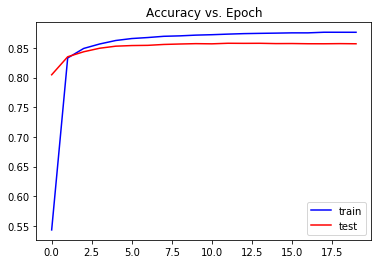

In [116]:
plt.figure()
plt.title("Accuracy vs. Epoch")
plt.plot(range(num_epochs), train_acc, color = "b", label = "train")
plt.plot(range(num_epochs), val_acc, color = "r", label = "test")
plt.legend(loc='lower right')

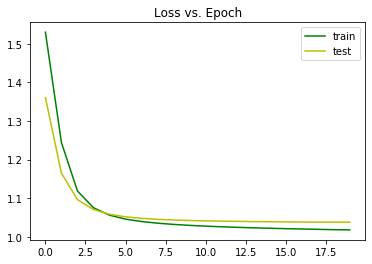

In [32]:
plt.figure()
plt.title("Loss vs. Epoch")
plt.plot(range(num_epochs), train_loss, color = "g", label = "train")
plt.plot(range(num_epochs), val_loss, color = "y", label = "test")
plt.legend(loc='upper right')

Now let's look at the rating predictions from the neural net. We do a similar analysis as we did for the RandomForest model.

In [130]:
output_test = trained_model(torch.Tensor(X_test)).detach().numpy()
Y_pred_nn = output_test.argmax(axis=1)+1
Counter(Y_pred_nn)

Counter({1: 3872, 2: 3908, 3: 4262, 4: 3957, 5: 4001})

In [144]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(Y_test, Y_pred_nn))

              precision    recall  f1-score   support

           1       0.93      0.90      0.91      4000
           2       0.89      0.87      0.88      4000
           3       0.84      0.89      0.86      4000
           4       0.81      0.80      0.81      4000
           5       0.82      0.82      0.82      4000

    accuracy                           0.86     20000
   macro avg       0.86      0.86      0.86     20000
weighted avg       0.86      0.86      0.86     20000



In [147]:
conf_nn = confusion_matrix(Y_test, Y_pred_nn)
conf_nn

array([[3586,   75,   50,  117,  172],
       [  84, 3476,  140,  144,  156],
       [  22,  102, 3567,  200,  109],
       [  65,  115,  342, 3212,  266],
       [ 115,  140,  163,  284, 3298]])

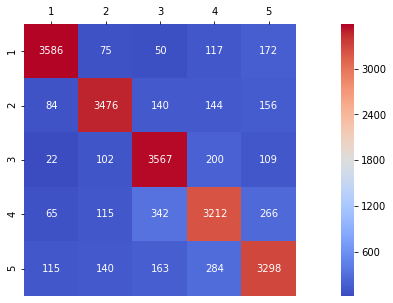

In [156]:
plt.figure(figsize = (16,5))
ax = sns.heatmap(conf_nn, cmap = 'coolwarm', square=True, annot = True, 
                 fmt='g', xticklabels = range(1,6), yticklabels = range(1,6))
ax.xaxis.set_ticks_position('top')

We can see that the neural net performs much better than the random forest model in terms of accuracy, precision and recall. However they both seem to predict low ratings better than high ratings. It could be because the bad reviews have more distinct features, where as neutral and good reviews are hard to distinguish.

#### Neural Net On Full Feature Set

Previously we use the outputs from the topic models (P = 1000) to predict star ratings. Now let's do another experiment using the same neural net to predict ratings from the full data set (P=18716, dense version of reviews bow, without TFIDF or LSI model).

In [128]:
X_train_full = dense_corpus_full[train]
Y_train = ratings[train]
X_test_full = dense_corpus_full[test]
Y_test = ratings[test]
print("X_train: ", X_train_full.shape)
print("Y_train: ", Y_train.shape)
print("X_test: ", X_test_full.shape)
print("Y_test: ", Y_test.shape)

X_train:  (80000, 18716)
Y_train:  (80000,)
X_test:  (20000, 18716)
Y_test:  (20000,)


In [129]:
batch_size = 64

train_data_full = Dataset(X_train_full, Y_train)
val_data_full = Dataset(X_test_full, Y_test)

train_loader_full = DataLoader(dataset = train_data_full, batch_size = batch_size,
                              shuffle = True)
val_loader_full = DataLoader(dataset = val_data_full, batch_size = batch_size,
                              shuffle = True)

In [130]:
num_epochs = 10
learning_rate = 1e-4

model = FFNet(n = len(reviews_dict))
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

trained_model_full, train_acc, train_loss, val_acc, val_loss = train_model(model, criterion, 
                                                    num_epochs, train_loader_full, 
                                                    val_loader_full, optimizer)

Train-epoch 0. Iteration 00300, Avg-Loss: 1.6059, Accuracy: 0.2942
Train-epoch 0. Iteration 00600, Avg-Loss: 1.5827, Accuracy: 0.4865
Train-epoch 0. Iteration 00900, Avg-Loss: 1.5317, Accuracy: 0.5818
Train-epoch 0. Iteration 01200, Avg-Loss: 1.4740, Accuracy: 0.6385
Validation-epoch 0. Avg-Loss: 1.2276, Accuracy: 0.8413
Train-epoch 1. Iteration 00300, Avg-Loss: 1.1829, Accuracy: 0.8548
Train-epoch 1. Iteration 00600, Avg-Loss: 1.1560, Accuracy: 0.8591
Train-epoch 1. Iteration 00900, Avg-Loss: 1.1360, Accuracy: 0.8625
Train-epoch 1. Iteration 01200, Avg-Loss: 1.1219, Accuracy: 0.8635
Validation-epoch 1. Avg-Loss: 1.0717, Accuracy: 0.8668
Train-epoch 2. Iteration 00300, Avg-Loss: 1.0512, Accuracy: 0.8860
Train-epoch 2. Iteration 00600, Avg-Loss: 1.0468, Accuracy: 0.8865
Train-epoch 2. Iteration 00900, Avg-Loss: 1.0443, Accuracy: 0.8859
Train-epoch 2. Iteration 01200, Avg-Loss: 1.0410, Accuracy: 0.8867
Validation-epoch 2. Avg-Loss: 1.0408, Accuracy: 0.8744
Train-epoch 3. Iteration 00300,

We can see that training the neural net on the full feature set (P = 18716) only yields a slightly better accuracy compared to reduced output from the topic model (P = 1000) but with drastically different training time. The previous models takes less than 2 mins to train 20 epochs. However the full feature set took more than 30 mins to training only 10 epochs. So we can conclude that reducing the dimensions of the data using topic model is helpful in predicting star rating.